# Policy Gradient - Cartpole

For Q-learning, the actions are determistic discrete space characterised by Q values (so we can say that the actions are picked by their corresponding Q values. ). But in reality, the actions can be continous and/or stochastic. So we instroduce a on-policy method where actions are choosed based on their distributions rather than on determistic values.

We can represent the policy distribution by $P(a|\pi_\theta(s))$ where $\pi_\theta(s)$ is the policy paramerized by $\theta$. So when the state is given, the action distribution is determined by the policy $\pi_\theta$.

For a discrete action space, the distribution can be represented using a categorical distribution of all possible actions. So the distribution can be computed as:
$$ p_i = \frac{e^{l_i}}{\sum{e^{l_j}}} ~~ i\in(0,...,N)$$
Where $N$ is the action space dimension.

In practice, the policy is not known, so we can represent it by a network.

Diferent from the Q-learning, for policy, we maximize the expectation of the probabilistic cumulatated reward.
$$E_{\pi_\theta}[R] = \int_a R(a)  P(a|\pi_\theta(s))$$
where $R(a)$ is the discounted cumulated rewards $R(a) = \sum \gamma r$ denoting a policy trajectory.

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import HTML
from cartpole_utils import env_cartpole, display_frames_as_gif, goalAchieved, test_cartpole

In [2]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 728)
        self.fc2 = nn.Linear(728, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, state):
        out = torch.relu(self.fc1(state))
        out = torch.relu(self.fc2(out))
        logits = self.fc3(out)
        return logits

In [3]:
class ReplayMemory:
    def __init__(self):
        self.games = []

    def add(self, attrib:list):
        self.games.append(attrib)
        
    def __len__(self):
        return len(self.games)
    
    def clear(self):
        self.games.clear()
    
    def sample(self):
        out = []
        for i in range(len(self.games[0])):
            data = np.array([items[i] for items in self.games])
            if len(data.shape) == 1:
                data = torch.from_array(data).unsqueeze(0)
            out.append(data)
        return out


In [5]:
class DQLAgent:
    def __init__(self, net):
        self.model = net
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001)

    def act(self, state):
        if isinstance(state, np.ndarray):
            if len(state) == 1:
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            else:
                state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            probs = F.softmax(self.model(state), dim=-1).detach()
            action = torch.multinomial(probs, 1).item() # probabilistic sampling
        return action
    
    def learn(self, plays, alpha=0.9, gamma=0.99):

        def cum_reward(rewards, gamma=0.99):
            cum_rewards = torch.zeros_like(rewards).to(torch.float32)
            for j in range(len(rewards))[::-1]:
                cum_rewards[j] = rewards[j] + gamma * (cum_rewards[j+1] if j+1<len(rewards) else 0)
            eps = np.finfo(np.float32).eps.item()
            cum_rewards = (cum_rewards - cum_rewards.mean()) / (cum_rewards.std() + eps)
            return cum_rewards

        # get data
        samples = plays.sample()
        
        # get samples batch
        states, rewards, actions,_ = samples

        # compute cumulated reward
        rewards_cum = cum_reward(rewards)

        # Cross-entropy loss is -log P in categorical distribution.
        # compute probabilities
        logits = self.model(states)
        log_probs = F.cross_entropy(logits, actions, reduction="none")
        
        # update network
        loss = (log_probs * rewards_cum).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.detach().item()

In [6]:
# train

epochs = 2000
state_num = 4 # 
action_num = 2
memory = ReplayMemory()
model = PolicyNet(state_num, action_num)
agent = DQLAgent(model)

scores = []
losses = []

for e in range(epochs):
    # reset environment
    state, _ = env_cartpole.reset()

    currState = state
    done = False

    score = 0
    tot_loss = 0
    count = 0

    # run an episode
    while not done :
        
        # choose action
        action = agent.act(state)

        # take action on env
        state, reward, done, info, _ = env_cartpole.step(action)
        
        # add to replay memory
        memory.add([currState, reward, action, done])

        currState = state.copy()

        # update score
        score += 1

        if score > 800:
            break

    # train
    loss = agent.learn(memory)

    # clear memory
    memory.clear()
    
    scores = np.append(scores, score)
    losses = np.append(losses, loss)

    if (e+1)%100 == 0:
        print(f"epoche: {e+1}, score: {score}, loss: {loss:.6f}")
    if goalAchieved(scores):
        break

/tmp/ipykernel_27715/118793377.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  tensor = torch.tensor([items[i] for items in self.games])


epoche: 100, score: 32, loss: -0.076434
epoche: 200, score: 109, loss: -0.815090
epoche: 300, score: 215, loss: -6.185280
epoche: 400, score: 136, loss: -4.486199
epoche: 500, score: 50, loss: -4.081884
epoche: 600, score: 64, loss: 1.712429
epoche: 700, score: 75, loss: -1.720667
epoche: 800, score: 110, loss: -1.846624
epoche: 900, score: 549, loss: -2.956296
epoche: 1000, score: 18, loss: -2.356297
epoche: 1100, score: 199, loss: -3.457239
epoche: 1200, score: 668, loss: 5.056186


In [9]:
frames = test_cartpole(env_cartpole, 300, agent=agent)
anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

301


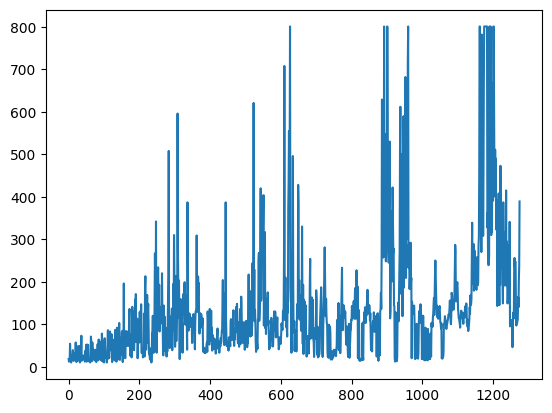

In [10]:
plt.plot(scores)